In [1]:
import numpy as np
import pandas as pd
import os,time, matplotlib
import matplotlib.pyplot as plt
import datetime,time,json
import multiprocessing

from newsplease import NewsPlease
from utils import GoogleNews

# Start Loading all files from folder

In [2]:
INPUT_PATH = '../data/articles'

In [3]:
paths = [os.path.join(INPUT_PATH,x) for x in os.listdir(INPUT_PATH)]

In [4]:
alldicts = []
for file in paths:
    with open(file,'r') as fi:
        try:
            d = json.load(fi)
            alldicts.append(d)
        except Exception as e:
            pass

In [5]:
df = pd.DataFrame(alldicts).dropna(subset = 'maintext').reset_index(drop=True)

# Data Cleaning 
Remove incorrect results like scraping errors

In [6]:
# Filter out newline escape chars

df = df.assign(maintext = df.maintext.str.replace('\n',' '))

print('Initial Number of articles:',len(df))

Initial Number of articles: 9011


## cleaning should take care of incorrect text: javascript browser cookies
Out of all articles N are featuring web error related stopwords, as initial preprocessing we can discard them

In [7]:
check = df.maintext.str.contains('java|javascript|cookie|browser', regex=True)
check.sum()

353

In [8]:
for row in  df[check].maintext.drop_duplicates():
    print(row)
    print('-----')

Why did this happen? Please make sure your browser supports JavaScript and cookies and that you are not blocking them from loading. For more information you can review our Terms of Service and Cookie Policy.
-----
The World Health Organisation has suggested it is time for countries to have a conversation about mandatory COVID-19 vaccines, saying: "It's a healthy debate to have." Robb Butler, executive director for WHO Europe, told Kay Burley on Sky News: "Mandatory vaccination can, but doesn't always increase uptake." However, he suggested countries - and individuals - should now be thinking about the issue. Live COVID updates from across the UK and around the world He added: "There are lessons of history here where mandates have come at the expense of trust, social inclusion. So it is very delicate, but we believe it is time to have that conversation, from an individual and population-based perspective." Advertisement Cases are rising again in much of Europe - sharply in the case of c

In [9]:
df = df[-check]

# Preprocessing

In [10]:
# To lower case
df['maintext'] = df.maintext.str.lower()
# Remove commas
df['maintext'] = df['maintext'].str.replace('[,;/]','', regex=True)

## add country info

In [11]:
countries = ['uk','usa','Austria','Belgium','Bulgaria','Croatia',
             'Cyprus','Czech','Denmark',
             'Estonia','Finland','France','Germany','Greece',
             'Hungary','Ireland','Italy','Latvia','Lithuania',
             'Luxembourg','Malta','Netherlands','Poland','Portugal',
             'Romania','Slovakia','Slovenia','Spain','Sweden']
countries = [x.lower() for x in countries]

pat = '|'.join(countries)
pat

'uk|usa|austria|belgium|bulgaria|croatia|cyprus|czech|denmark|estonia|finland|france|germany|greece|hungary|ireland|italy|latvia|lithuania|luxembourg|malta|netherlands|poland|portugal|romania|slovakia|slovenia|spain|sweden'

In [12]:
words = df.maintext.str.split('\s+', regex=True)
country = df.maintext.str.findall(pat)

df = df.assign(country = country.apply(lambda x: list(set(x))))

## Check text length

it might make sense to just drop articles incredibly long

In [13]:
df = df.assign(numchars = df.maintext.apply(lambda x: len(x.replace(' ',''))))
df = df.assign(numwords = df.maintext.apply(lambda x: len(x.split(' '))))
df.head()

,id,title,link,published,maintext,country,numchars,numwords
0,8f585a5d26a3b5820b5f7e1e3feec996,Coronavirus - Austria travel advice - GOV.UK,https://www.gov.uk/foreign-travel-advice/austr...,"Sat, 21 Mar 2020 10:13:56 GMT",coronavirus travel health check the latest inf...,"[ireland, uk, austria]",4189,799
2,3e501254f150cdd429158e614bf72cf5,"Fully vaccinated people, newborns exempt from ...",https://www.irishcentral.com/travel/mandatory-...,"Thu, 15 Apr 2021 07:00:00 GMT",update: ireland's department of health has pro...,[ireland],4273,807
3,43e29e6f21d43c2425202f92e7577a3d,"Czech state of emergency ends, new regulations...",https://www.expats.cz/czech-news/article/czech...,"Mon, 20 Dec 2021 08:00:00 GMT",the national institute of public health (szú) ...,[czech],717,137
4,f0d921dc86890542efb318f3214d44af,More than 30 Mount Athos monks fell asleep in ...,https://orthodoxtimes.com/more-than-30-mount-a...,"Mon, 21 Feb 2022 08:00:00 GMT",the coronavirus continues to make its presence...,[bulgaria],1976,393
5,732c697e431b88c523d682820db527d3,Latvia Determines Vaccination Certificates Val...,https://www.schengenvisainfo.com/news/latvia-d...,"Fri, 07 Jan 2022 08:00:00 GMT",the latvian government came to terms on covid-...,[latvia],2140,424


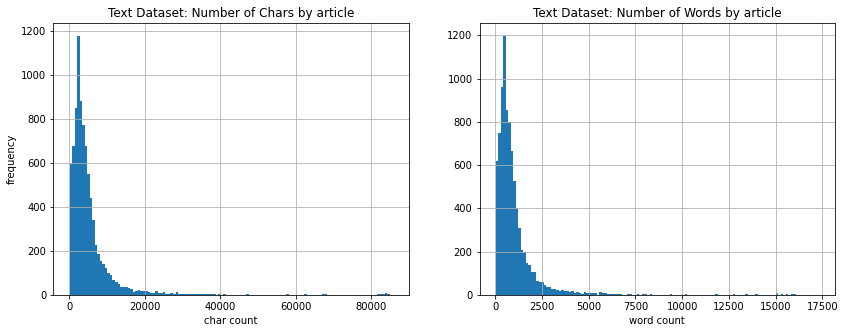

In [14]:
fig,[ax,ax2] = plt.subplots(figsize = (14,5), ncols=2)
df.numchars.hist(bins=128,ax=ax)
df.numwords.hist(bins=128,ax=ax2)

ax.set_xlabel('char count')
ax2.set_xlabel('word count')

ax.set_ylabel('frequency')
ax.set_title('Text Dataset: Number of Chars by article')
ax2.set_title('Text Dataset: Number of Words by article')
plt.show()

In [15]:
quantiles90 = df[['numchars','numwords']].apply(lambda x :x.quantile(.9).round(-3))

quantiles90

numchars    10000.0
numwords     2000.0
dtype: float64

In [16]:
df = df[(df.numwords<=quantiles90.numchars) & (df.numchars<=quantiles90.numchars)]

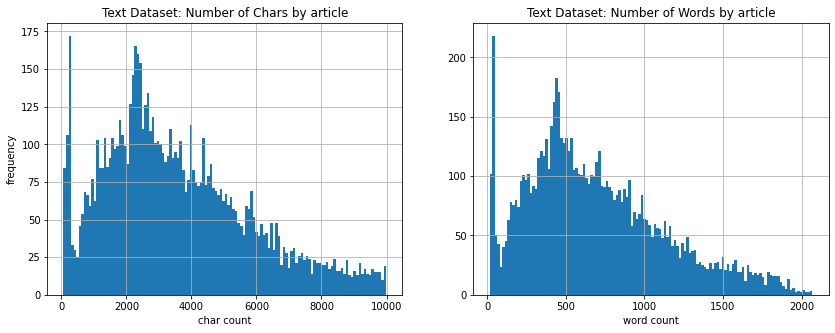

In [17]:
fig,[ax,ax2] = plt.subplots(figsize = (14,5), ncols=2)
df.numchars.hist(bins=128,ax=ax)
df.numwords.hist(bins=128,ax=ax2)

ax.set_xlabel('char count')
ax2.set_xlabel('word count')

ax.set_ylabel('frequency')
ax.set_title('Text Dataset: Number of Chars by article')
ax2.set_title('Text Dataset: Number of Words by article')
plt.show()

In [18]:
# Lowerbound

quantiles10 = df[['numchars','numwords']].apply(lambda x :x.quantile(.01).round(-1))

quantiles10

numchars    140.0
numwords     30.0
dtype: float64

In [19]:
for i in df[df.numwords<25].maintext:
    print('---------')
    print(i)    

---------
a tourist on a boat on the southern thai island of koh phi phi in 2019. photo: afp
---------
logo_ddn_tag_site jn with tagline logo-sns_tag_site our apologies unfortunately our website is currently unavailable in most european countries due to gdpr rules.
---------
covid live news updates: delhi reports 1414 new covid-19 cases 1171 recoveries and 1 death in the last 24 hours
---------
travellers arrive at singapore’s changi airport. visitors are flocking to the quarantine-free city state. photo: afp
---------
omicron covid news updates: new guidelines for international arrivals 14 days travel details negative rt-pcr test report mandatory from december 1
---------
apasionado por la industria aerocomercial. despachante de aeronaves operador de rampa y señalero. coordinador editorial de aviacionline. contacto: gaston.sena@aviacionline.com
---------
thank you for following dh's updates on covid-19 here. we will be back for more updates tomorrow!
---------
most major global airlin

In [20]:
# Number of articles by date

In [21]:
dates = (pd.to_datetime(df.published)).dt.to_period('M')

/home/rba/Projects/cultural-analytics/venv_culturalanalytics/lib/python3.8/site-packages/pandas/core/arrays/datetimes.py:1162: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  warnings.warn(


<AxesSubplot:>

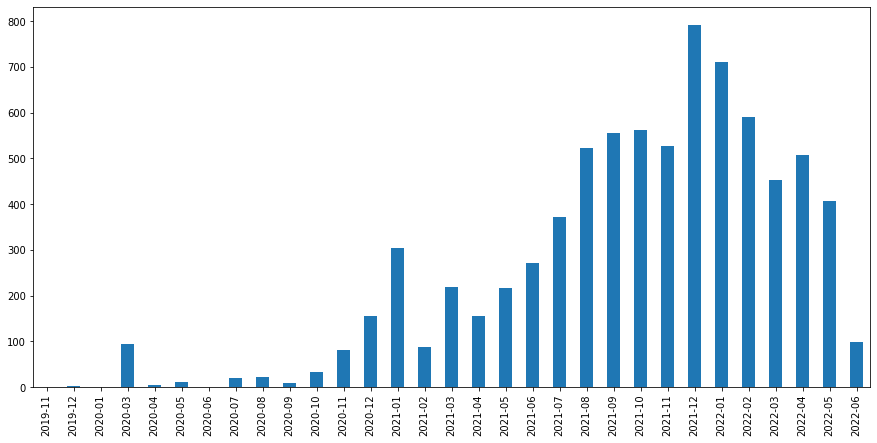

In [22]:
dates.value_counts().sort_index().plot.bar(figsize=(15,7))

# Save Dataset

In [23]:
df.head()

,id,title,link,published,maintext,country,numchars,numwords
0,8f585a5d26a3b5820b5f7e1e3feec996,Coronavirus - Austria travel advice - GOV.UK,https://www.gov.uk/foreign-travel-advice/austr...,"Sat, 21 Mar 2020 10:13:56 GMT",coronavirus travel health check the latest inf...,"[ireland, uk, austria]",4189,799
2,3e501254f150cdd429158e614bf72cf5,"Fully vaccinated people, newborns exempt from ...",https://www.irishcentral.com/travel/mandatory-...,"Thu, 15 Apr 2021 07:00:00 GMT",update: ireland's department of health has pro...,[ireland],4273,807
3,43e29e6f21d43c2425202f92e7577a3d,"Czech state of emergency ends, new regulations...",https://www.expats.cz/czech-news/article/czech...,"Mon, 20 Dec 2021 08:00:00 GMT",the national institute of public health (szú) ...,[czech],717,137
4,f0d921dc86890542efb318f3214d44af,More than 30 Mount Athos monks fell asleep in ...,https://orthodoxtimes.com/more-than-30-mount-a...,"Mon, 21 Feb 2022 08:00:00 GMT",the coronavirus continues to make its presence...,[bulgaria],1976,393
5,732c697e431b88c523d682820db527d3,Latvia Determines Vaccination Certificates Val...,https://www.schengenvisainfo.com/news/latvia-d...,"Fri, 07 Jan 2022 08:00:00 GMT",the latvian government came to terms on covid-...,[latvia],2140,424


In [26]:
df.to_csv('../data/text_dataset/articles_v0.csv',sep=';', index=None)
df.to_excel('../data/text_dataset/articles_v0.xlsx',index=None)